<a href="https://colab.research.google.com/github/Sarahiperbolica/Masterclass_OG_2025/blob/main/Turorials_ita/Tuto_3_Matched_filtering_introduction_ita.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<span style="float: left;padding: 1.3em">![logo](https://github.com/gw-odw/odw-2024/blob/main/Tutorials/logo.png?raw=1)</span>

# Workshop sulle Onde Gravitazionali

## Tutorial 3 PyCBC Tutorial, Introduzione al filtraggio abbinato
In questo tutorial, impareremo come trovare un segnale di onda gravitazionale nei dati reali provenienti da LIGO e Virgo! Per fare ciò, utilizzeremo la libreria [PyCBC](http://github.com/ligo-cbc/pycbc). PyCBC è uno strumento utilizzato dagli scienziati per studiare le onde gravitazionali, trovare segnali provenienti da buchi neri o stelle di neutroni in collisione e analizzare le loro proprietà. È uno degli stessi strumenti utilizzati dai ricercatori nelle collaborazioni LIGO e Virgo per rilevare vere onde gravitazionali.

Introduciamo un metodo chiamato **filtraggio abbinato**, che ci aiuta a trovare un segnale specifico nascosto nei dati. Esploreremo prima come funziona questo metodo confrontando i segnali sia nel **dominio del tempo** che nel **dominio della frequenza**.

💡 **Vuoi saperne di più?**  
Dai un'occhiata a più [esempi e tutorial](http://pycbc.org/pycbc/latest/html/#library-examples-and-interactive-tutorials) o consulta la documentazione completa di [PyCBC](http://pycbc.org/pycbc/latest/html/py-modindex.html).

Vuoi provarlo? **Clicca [su questo link](https://colab.research.google.com/github/Sarahiperbolica/Masterclass_OG_2025/blob/main/Turorials_ita/Tuto_3_Matched_filtering_introduction_ita.ipynb)** per aprire questo tutorial su **Google Colaboratory**, dove puoi eseguire il codice in modo interattivo! 🚀

## Installazione



In [ ]:
# -- Uncomment following line if running in Google Colab
! pip install --upgrade pip setuptools wheel
! pip install git+https://github.com/gwastro/pycbc.git

  Cloning https://github.com/gwastro/pycbc.git to /tmp/pip-req-build-o3i48q25
  Running command git clone --filter=blob:none --quiet https://github.com/gwastro/pycbc.git /tmp/pip-req-build-o3i48q25
  Resolved https://github.com/gwastro/pycbc.git to commit 0115065918cdf9ef3a58a53a5800d7b0838625b9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 35.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 MB 77.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 MB 5

## Filtraggio abbinato: Trovare segnali ben modellati nel rumore gaussiano

Il **filtraggio abbinato** è uno dei metodi più efficaci per rilevare segnali noti quando il **rumore di fondo è gaussiano** (cioè casuale ma ben comportato). Non preoccuparti se questi termini ti suonano strani—li esploreremo più nel dettaglio tra poco!

Per ora, vediamo il filtraggio abbinato in azione partendo da un caso semplice:

Immagina di avere un set di dati che contiene solo rumore casuale (iniziamo con il "**rumore bianco**", che significa un rumore distribuito uniformemente su tutte le frequenze). Riusciamo comunque a trovare un segnale nascosto dentro? Scopriamolo insieme!

In [ ]:
import numpy
import pylab

# specifica la frequenza di campionamento.
# I dati grezzi di LIGO sono campionati a 16384 Hz (= 2^14 campioni/secondo).
# Catturano il contenuto di frequenza del segnale fino a f_Nyquist = 8192 Hz.
# Qui, per rendere il calcolo più veloce, campioneremo a una frequenza inferiore.
sample_rate = 1024 # campioni per secondi
data_length = 1024 # secondi

# Genera una lunga serie di rumore bianco: la serie di dati e la serie temporale.
data = numpy.random.normal(size=[sample_rate * data_length])
times = numpy.arange(len(data)) / float(sample_rate)

E poi aggiungiamo un segnale di onda gravitazionale a una parte casuale di questi dati.

In [ ]:
from pycbc.waveform import get_td_waveform

# l'"approssimante" (gergo per famiglia di onde parametrizzate).
# IMRPhenomD (un modello fenomenologico di onda di tipo Inspiral–Merger–Ringdown) è definito nel dominio delle frequenze, ma lo otteniamo nel dominio del tempo (td).
apx = 'IMRPhenomD'


Puoi specificare [molti parametri](https://pycbc.org/pycbc/latest/html/pycbc.waveform.html?highlight=get_td_waveform#pycbc.waveform.waveform.get_td_waveform), ma qui useremo i valori predefiniti per tutto, tranne che per le masse.

Come abbiamo visto nel Tutorial 2, `get_td_waveform` restituisce sia $h_+$ che $h_{\times}$, ma per ora useremo solo $h_+$.

In [ ]:
hp1, _ = get_td_waveform(approximant=apx,
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/sample_rate,
                         f_lower=25)

Le onde gravitazionali sono **incredibilmente deboli**—la loro ampiezza tipica è di circa **\(10^{-20}\)**! Questo corrisponde a **1 parte su 100 miliardi di miliardi**—troppo piccola per essere vista senza rilevatori molto sensibili come LIGO e Virgo.

Per rendere le cose più facili da comprendere, **normalizziamo** il nostro segnale. Ciò significa che lo adattiamo in modo che, quando lo confrontiamo con se stesso, otteniamo un valore di **1**.

Facendo questo, possiamo pensare alla **correlazione incrociata** (quanto due segnali sono simili) come a un **rapporto segnale/rumore (SNR)**. Se l'SNR è alto, il nostro segnale si distingue dal rumore. Se è basso, il segnale è sepolto nel rumore.

### Cos'è il Rapporto Segnale/Rumore (SNR)?

Il **Rapporto Segnale/Rumore (SNR)** è un modo per misurare quanto è forte un segnale rispetto al rumore di fondo. Pensalo come cercare di sentire qualcuno che sussurra in una stanza rumorosa—più forte è il sussurro (segnale) rispetto al chiacchiericcio di fondo (rumore), più facile è sentirlo.

Le onde gravitazionali sono **estremamente deboli**, quindi possono facilmente perdersi nel rumore del rilevatore. Gli scienziati usano il **filtraggio abbinato** (una tecnica per confrontare i dati con modelli di segnali noti) per **aumentare l'SNR** e aiutare a trovare segnali reali di onde gravitazionali.

Matematicamente, l'SNR viene calcolato confrontando la forza del segnale con il livello di rumore. Un SNR più alto significa una rilevazione più chiara.

- **SNR > 8** → Probabilmente una vera onda gravitazionale  
- **SNR < 5** → Probabilmente solo rumore  

Immagina di ascoltare una canzone con le cuffie:  
- **Alto SNR**: La musica è chiara e puoi sentire ogni nota.  
- **Basso SNR**: C'è troppo rumore di fondo e la canzone è difficile da riconoscere.  

In [ ]:
#Normalizzazione
hp1 = hp1 / max(numpy.correlate(hp1, hp1, mode='full'))**0.5

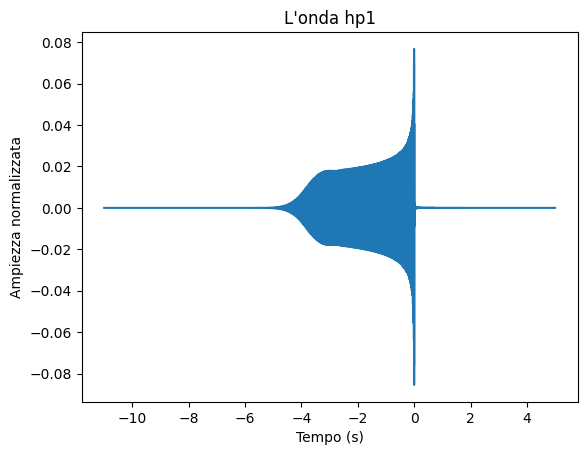

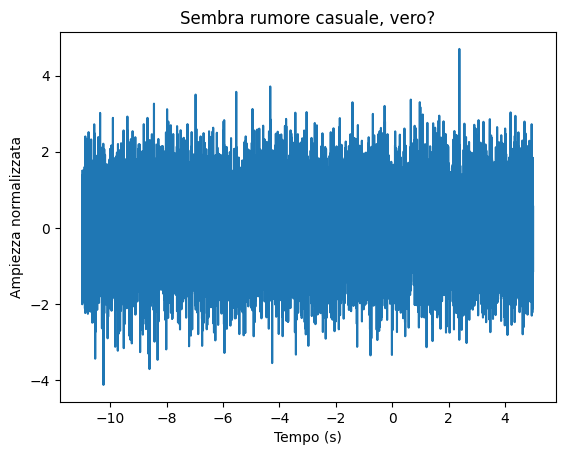

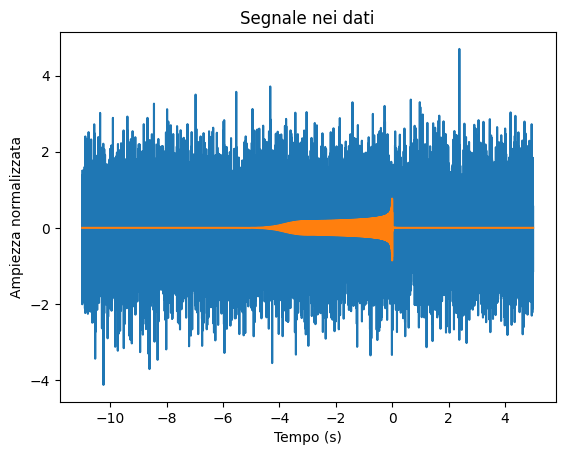

In [ ]:
%matplotlib inline
# nota che in questa figura, l'ampiezza dell'onda è dell'ordine di 1.
# La durata (per frequenze superiori a f_lower=25 Hz) è di soli 3 o 4 secondi.
# L'onda è "sfumata": aumenta lentamente da zero fino alla massima ampiezza, nel primo secondo circa.
# È zero-padded nei tempi precedenti.
pylab.figure()
pylab.title("L'onda hp1")
pylab.plot(hp1.sample_times, hp1)
pylab.xlabel('Tempo (s)')
pylab.ylabel('Ampiezza normalizzata')

# Sposta l'onda per farla iniziare a un tempo casuale nei dati di rumore gaussiano.
waveform_start = numpy.random.randint(0, len(data) - len(hp1))
data[waveform_start:waveform_start+len(hp1)] += 10 * hp1.numpy()

pylab.figure()
pylab.title("Sembra rumore casuale, vero?")
pylab.plot(hp1.sample_times, data[waveform_start:waveform_start+len(hp1)])
pylab.xlabel('Tempo (s)')
pylab.ylabel('Ampiezza normalizzata')

pylab.figure()
pylab.title("Segnale nei dati")
pylab.plot(hp1.sample_times, data[waveform_start:waveform_start+len(hp1)])
pylab.plot(hp1.sample_times, 10 * hp1)
pylab.xlabel('Tempo (s)')
pylab.ylabel('Ampiezza normalizzata')
pylab.show()

Per trovare il segnale delle onde gravitazionali nascosto nei dati rumorosi, utilizziamo un metodo chiamato **correlazione incrociata**. La correlazione incrociata è un metodo matematico per confrontare due segnali. Ci aiuta a capire se un **modello** (come l'onda gravitazionale attesa) appare da qualche parte nel dataset.

Come la usiamo qui?
* Prendiamo un segnale noto (un **modello** di onda gravitazionale).
* Lo **scivoliamo** su tutto il dataset, confrontandolo a ogni passo temporale.
* Il risultato è un **nuovo dataset che mostra quanto bene il segnale corrisponde** a ogni punto nel tempo.

Poiché controlliamo ogni possibile posizione del segnale nei dati, il processo richiede un **lungo tempo**, specialmente per dataset di grandi dimensioni. Questo serve solo a dimostrare il metodo, e successivamente vedremo modi più veloci per farlo utilizzando tecniche ottimizzate.

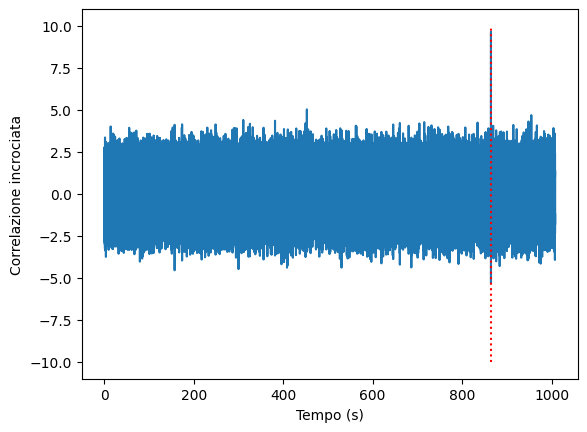

In [ ]:
%matplotlib inline
# Calcolare la correlazione incrociata
cross_correlation = numpy.zeros([len(data)-len(hp1)])
hp1_numpy = hp1.numpy()
for i in range(len(data) - len(hp1_numpy)):
    cross_correlation[i] = (hp1_numpy * data[i:i+len(hp1_numpy)]).sum()

# Tracciare i dati correlati nel tempo. Sovrapporre la posizione della fine del segnale;
# è qui che dovremmo trovare un picco nella correlazione incrociata.
pylab.figure()
times = numpy.arange(len(data) - len(hp1_numpy)) / float(sample_rate)
pylab.plot(times, cross_correlation)
pylab.plot([waveform_start/float(sample_rate), waveform_start/float(sample_rate)], [-10,10],'r:')
pylab.xlabel('Tempo (s)')
pylab.ylabel('Correlazione incrociata')
pylab.show()


### Detection in rumore colorato

Ecco la traduzione:

Fino ad ora, abbiamo usato il rumore bianco, il che significa che tutte le frequenze hanno lo stesso livello di variazione casuale. Ma i **veri rilevatori di onde gravitazionali**, come LIGO, non hanno rumore bianco—hanno un **"rumore colorato"**, dove alcune frequenze sono più rumorose di altre.

Cos'è il "Rumore Colorato"? Se il rumore bianco ha lo stesso livello di casualità in ogni frequenza, il rumore colorato ha alcune frequenze più forti (più rumore), mentre altre sono più deboli (meno rumore). Il rumore di LIGO segue uno schema specifico chiamato **rumore ad alta potenza con zero detuning**, che deriva dal design e dalla sensibilità del rilevatore.

Cosa Stiamo Facendo Ora?
* Genereremo un nuovo set di dati utilizzando la **curva del rumore realistico** di LIGO invece del rumore bianco.
* Ripeteremo il nostro processo di **correlazione incrociata** per cercare il segnale in questo rumore più realistico.
* Questo ci mostrerà come funziona il **filtro abbinato** nei dati reali delle onde gravitazionali.

I veri dati di LIGO sono molto più complessi rispetto al semplice rumore bianco. Usare il rumore colorato ci aiuta a capire come le onde gravitazionali vengono rilevate negli esperimenti reali!

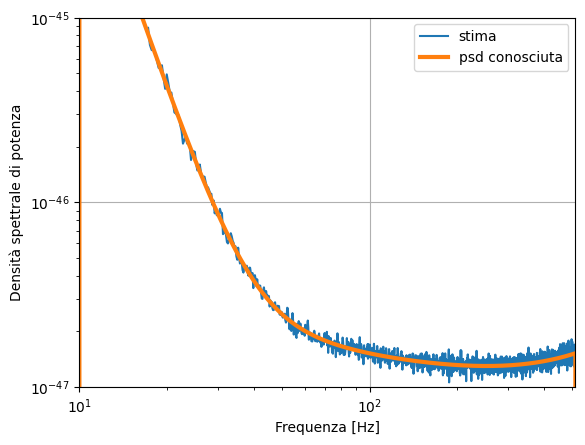

In [ ]:
%matplotlib inline
# http://pycbc.org/pycbc/latest/html/noise.html
import pycbc.noise
import pycbc.psd

# Il colore del rumore corrisponde a una PSD che fornisci:
# Genera una PSD che corrisponde alla curva di rumore ad alta potenza zero-detuned di Advanced LIGO
flow = 10.0
delta_f = 1.0 / 128
flen = int(sample_rate / (2 * delta_f)) + 1
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

# Genera rumore colorato
delta_t = 1.0 / sample_rate
ts = pycbc.noise.noise_from_psd(data_length*sample_rate, delta_t, psd, seed=127)

# Stima la densità spettrale di ampiezza (ASD = sqrt(PSD)) per i dati rumorosi
# utilizzando il metodo "welch". Sceglieremo campioni di PSD di 4 secondi con sovrapposizione del 50%
seg_len = int(4 / delta_t)
seg_stride = int(seg_len / 2)
estimated_psd = pycbc.psd.welch(ts, seg_len=seg_len, seg_stride=seg_stride)

# Plotta:
pylab.loglog(estimated_psd.sample_frequencies, estimated_psd, label='stima')
pylab.loglog(psd.sample_frequencies, psd, linewidth=3, label='psd conosciuta')
pylab.xlim(xmin=flow, xmax=512)
pylab.ylim(1e-47, 1e-45)
pylab.xlabel('Frequenza [Hz]')
pylab.ylabel('Densità spettrale di potenza')
pylab.legend()
pylab.grid()
pylab.show()

# Aggiungi il segnale, questa volta, con un'ampiezza "tipica".
ts[waveform_start:waveform_start+len(hp1)] += hp1.numpy() * 1E-20


Poiché il rumore di LIGO è colorato (alcune frequenze sono più rumorose di altre), dobbiamo "**sbiancare**" sia **i nostri dati** (il segnale rumoroso) che il **nostro modello di onda** (il modello dell'onda gravitazionale che stiamo cercando). Il processo di sbiancamento è una tecnica che fa sì che **tutte le frequenze abbiano lo stesso livello di rumore**. Questo ci aiuta a vedere più chiaramente il segnale dell'onda gravitazionale rimuovendo gli effetti del rumore di LIGO.

Lo facciamo nel **dominio delle frequenze** (dove analizziamo i segnali come onde con diverse frequenze). **Dividiamo** sia i dati che il modello di onda per la **Densità Spettrale di Potenza** (PSD). La PSD ci dice quanto rumore esiste a ciascuna frequenza—dividendo per essa, bilanciamo il rumore.

Una volta che abbiamo sbiancato i dati e il modello, possiamo applicare il **filtraggio abbinato** in modo molto più efficace, rendendo più **facile** rilevare i veri segnali di onde gravitazionali! 🚀

In [ ]:
%matplotlib inline
# Genera una PSD per sbiancare i dati
from pycbc.types import TimeSeries

# La PSD, campionata correttamente per i dati rumorosi
flow = 10.0
delta_f = 1.0 / data_length
flen = int(sample_rate / (2 * delta_f)) + 1
psd_td = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, 0)

# La PSD, campionata correttamente per il segnale
delta_f = sample_rate / float(len(hp1))
flen = int(sample_rate / (2 * delta_f)) + 1
psd_hp1 = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, 0)

# I valori 0 e N sono zero. Impostiamoli su un valore vicino per evitare la divisione per zero.
psd_td[0] = psd_td[1]
psd_td[len(psd_td) - 1] = psd_td[len(psd_td) - 2]
# Lo stesso per la PSD campionata per il segnale
psd_hp1[0] = psd_hp1[1]
psd_hp1[len(psd_hp1) - 1] = psd_hp1[len(psd_hp1) - 2]

# Converte sia i dati rumorosi che il segnale nel dominio delle frequenze,
# e divide ciascuno per ASD=PSD**0.5, quindi converte di nuovo nel dominio del tempo.
# Questo "sbianca" i dati e il modello del segnale.
# Moltiplicando il modello del segnale per 1E-21 lo mette nelle unità realistiche di strain.
data_whitened = (ts.to_frequencyseries() / psd_td**0.5).to_timeseries()
hp1_whitened = (hp1.to_frequencyseries() / psd_hp1**0.5).to_timeseries() * 1E-21


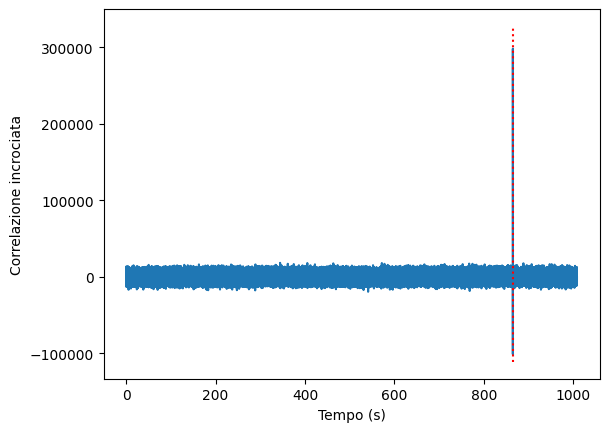

In [ ]:
%matplotlib inline
# Ora rifacciamo la correlazione, nel dominio del tempo, ma con i dati e il modello sbiancati.
cross_correlation = numpy.zeros([len(data)-len(hp1)])
hp1n = hp1_whitened.numpy()
datan = data_whitened.numpy()
for i in range(len(datan) - len(hp1n)):
    cross_correlation[i] = (hp1n * datan[i:i+len(hp1n)]).sum()

# traccia la correlazione incrociata nel dominio del tempo. Sovrapponi la posizione della fine del segnale.
# Nota quanto è più grande il picco della correlazione incrociata, rispetto al livello di rumore,
# rispetto alla versione non sbiancata della stessa quantità. Il rapporto segnale-rumore (SNR) è molto più alto!
pylab.figure()
times = numpy.arange(len(datan) - len(hp1n)) / float(sample_rate)
pylab.plot(times, cross_correlation)
pylab.plot([waveform_start/float(sample_rate), waveform_start/float(sample_rate)],
           [(min(cross_correlation))*1.1,(max(cross_correlation))*1.1],'r:')
pylab.xlabel('Tempo (s)')
pylab.ylabel('Correlazione incrociata')
pylab.show()